## Genetic Algorithm

In [7]:
import pandas as pd
import numpy as np
import random
from scipy.stats import pearsonr
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [8]:
a_df = pd.read_csv('alzheimers_disease_data.csv')
df =a_df.drop(['DoctorInCharge', 'PatientID'], axis=1, inplace=True)
X = a_df.drop('Diagnosis', axis = 1)
y = a_df['Diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
#defining the fitness function
def fitness_function(individual):
    selected_indices = [i for i, val in enumerate(individual) if val == 1]

    if len(selected_indices) == 0:
        return -1.0,  # Penalize empty selection

    correlation = []
    # Get selected features
    selected_features = X_train.iloc[:, selected_indices]
    #from selected features calculate correlation using pearson correlation
    for feature in range(len(selected_indices)):
        r, _= pearsonr((selected_features.iloc[:, feature].values), y_train.values)
        correlation.append(abs(r))
    
    mean_correlation = np.mean(correlation)

    model = DecisionTreeClassifier(random_state= 42)
    model.fit(selected_features, y_train)

    scores = cross_val_score(model, selected_features, y_train, cv=3, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    #fitness_score = mean_correlation , mean_accuracy
        
    return mean_correlation, mean_accuracy 




### Using DEAP to create Genetic Algorithm

In [10]:
#setting up the GA
creator.create("FitnessMax", base.Fitness, weights=(1.0,1.0))  # Maximize fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)  # Binary encoding (0 = ignore, 1 = select)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#Operators
toolbox.register("mate", tools.cxTwoPoint)  # Crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)  # Mutation probability
toolbox.register("select", tools.selNSGA2)  # Multi-objective selection selNSGA2 (Non-dominated Sorting Genetic Algorithm II) is well-suited for multi-objective optimization.
toolbox.register("evaluate", fitness_function)

C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [11]:
# --- Define Main GA Function ---
def main(pop_size, generations, cxpb, mutpb):
    population = toolbox.population(n=pop_size)

    # Evaluate initial population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    for g in range(generations):
        # Select the next generation
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutationi
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate new offspring
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update population
        population = toolbox.select(offspring, k=len(population))

    # Use sortNondominated to select the best individual(s)
    fronts = tools.sortNondominated(population, len(population))
    best_front = fronts[0]  # Front 1 contains the best non-dominated solutions

    # Find the individual with the highest correlation in the best front
    #find individual with highest correclation
    best_corr_individual = max(best_front, key=lambda ind: ind.fitness.values[0]) 
    #fitness.values[0]: Corr score
    # fitness.values[1]: Accuracy score
    #loops through best_corr_individual and selects the corresponding feature names from X_train.columns
    best_corr_features = [X_train.columns[i] for i in range(len(best_corr_individual)) if best_corr_individual[i] == 1]
    best_corr_value = best_corr_individual.fitness.values[0] #corr of the best individual

    # Find the individual with the highest accuracy in the best front
    best_acc_individual = max(best_front, key=lambda ind: ind.fitness.values[1])
    best_acc_features = [X_train.columns[i] for i in range(len(best_acc_individual)) if best_acc_individual[i] == 1]
    best_acc_value = best_acc_individual.fitness.values[1]

    combined_features = list(set(best_corr_features + best_acc_features))

    # Print results in the desired format
    #print(f"Correlation: {best_corr_value},\n Accuracy: {best_acc_value},\n Best Features: {combined_features}")

    return best_corr_value, best_acc_value, combined_features
    # # Get Best Individual
    # best_individual = tools.selBest(population, k=1)[0]
    # selected_features = [X.columns[i] for i in range(len(best_individual)) if best_individual[i] == 1]

    # print("Selected Features using Pearson Correlation GA: \n", selected_features)
    # return best_individual.fitness.values[0], selected_features



In [ ]:
runs = 5
corr_values = []
acc_values = []
for i in range(runs):
    best_corr_value, best_acc_value, selected_features = main(pop_size=300, generations=300, cxpb=0.9, mutpb=0.2)

    print("=" * 50)
    print(f"Run {i+1}:")
    print(f"Best Correlation Score: {best_corr_value:.4f}")
    print(f"Best Accuracy Score: {best_acc_value:.4f}")
    print("\nSelected Features:\n", selected_features)
    print("=" * 50, "\n")

    corr_values.append(best_corr_value)
    acc_values.append(best_acc_value)
    



Run 1:
Best Correlation Score: 0.2161
Best Accuracy Score: 0.9136

Selected Features:
 ['MemoryComplaints', 'Diabetes', 'FunctionalAssessment', 'ADL', 'PersonalityChanges', 'MMSE', 'BehavioralProblems']



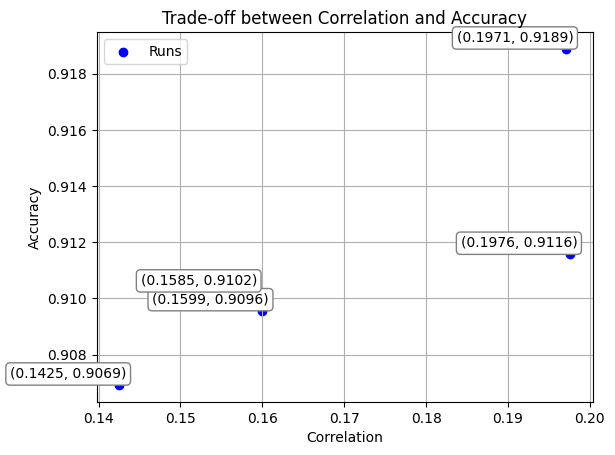

In [ ]:
plt.scatter(corr_values, acc_values, c='blue', marker='o', label='Runs')
for i in range(runs):
    plt.annotate(f'({corr_values[i]:.4f}, {acc_values[i]:.4f})',  
    (corr_values[i], acc_values[i]),  
    textcoords="offset points",  
    xytext=(5,5),  
    ha='right',  
    fontsize=10,  
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white'))

plt.xlabel('Correlation')
plt.ylabel('Accuracy')
plt.title('Trade-off between Correlation and Accuracy')
plt.grid(True)
plt.legend()
plt.show()